In [1]:
import lib.csv_helpers as csv
from IPython.display import display

## Generate Dummy Data
for testing / demo purposes.
Includes random surface chemistry mapping

In [ ]:

import lib.dummydata as dummydata

print("Generating Dummy tsv files with the following settings")
run_settings = dummydata.defaults

run_settings['instrument']['sensor'] = 'DUM01'

chem_map = dummydata.dummyChemistry(run_settings)
run_settings['instrument']['chemistry_map'] = chem_map

display(run_settings)

dummydata.generate_tsv(run_settings)

print("appending another data set with new sensor name")
run_settings['instrument']['sensor'] = 'DUM02'
dummydata.generate_tsv(run_settings, append=True)


## Preview of csv spectrometer data
Simply displaying a csv measurement file with pandas

In [1]:
import os
import pandas as pd
dir = "/Users/calum/git/Glasgow/sampleData/Beer x Bitter"
testfile = "HAN24_Sensor10_BeerBitter1_Rotation1.txt"
df = pd.read_csv(os.path.join(dir, testfile), sep='\t')

#label columns
reps = len(df.columns)-1
col_names = ['wavelength']
for r in range(reps):
	col_names = F"rep{r+1}")
df.columns = col_names
df

,wavelength,rep1,rep2,rep3
0,457.131,98.77,99.22,98.77
1,457.204,99.00,99.16,98.96
2,457.277,95.12,95.17,94.66
3,457.349,93.82,93.88,93.54
4,457.422,93.98,94.03,93.78
...,...,...,...,...
4090,730.534,66.20,65.54,66.02
4091,730.598,66.68,66.14,66.71
4092,730.661,67.71,67.92,67.83
4093,730.724,66.41,67.32,66.72


## Import from .txt or .csv files

### Input File

Requires a text file with at least 2 columns.
(They don't need to be named in the file)

[wavelength]	[transmission data 1]	...[transmission data n (optional)]

The default is for tab separation, but can be specified with:

separator = '\t'

### Regex
A regular expression must be provided to identify these Primary metadata fields from the filename:
* sensor
* element
* fluid

Optionally, extra fields can be identified, which will be added to the metadata:
* e.g. rotation


In [3]:
import lib.csv_helpers as csv

#Folder containing text/csv files to import
# input_dir = "/Users/calum/git/Glasgow/sampleData/combined"
input_dir = "/Users/calum/git/Glasgow/sampleData/Beer"
output_dir = 'sampledata'

# Construct a regex to extract metadata from the filename
# example 'HAN24_Sensor9_BeerBitter3_Rotation2.txt'
regex = '(?P<sensor>.+)_Sensor(?P<element>.+)_(?P<fluid>.+)_Rotation(?P<rotation>.+).txt'
# regex = '(?P<sensor>.+)_Sensor(?P<element>.+)_(?P<fluid>.+)_Rotation(.+).txt'

pkeys = [
    'date',
    'sensor',
    'element',
    'fluid',
    # 'rotation',
]

csv.import_dir_to_csv(input_dir, regex, output_dir, append=False, primary_keys=pkeys)


INFO:root:Saving data into new file 2022-03-01-HAN24-10-Beer.txt
INFO:root:imported HAN24_Sensor10_Beer_Rotation1.txt to sampledata/HAN24/2022-03-01-HAN24-10-Beer.txt
INFO:root:imported HAN24_Sensor10_Beer_Rotation2.txt to sampledata/HAN24/2022-03-01-HAN24-10-Beer.txt
INFO:root:imported HAN24_Sensor10_Beer_Rotation3.txt to sampledata/HAN24/2022-03-01-HAN24-10-Beer.txt
INFO:root:Saving data into new file 2022-03-01-HAN24-11-Beer.txt
INFO:root:imported HAN24_Sensor11_Beer_Rotation1.txt to sampledata/HAN24/2022-03-01-HAN24-11-Beer.txt
INFO:root:imported HAN24_Sensor11_Beer_Rotation2.txt to sampledata/HAN24/2022-03-01-HAN24-11-Beer.txt
INFO:root:imported HAN24_Sensor11_Beer_Rotation3.txt to sampledata/HAN24/2022-03-01-HAN24-11-Beer.txt
INFO:root:Saving data into new file 2022-03-01-HAN24-12-Beer.txt
INFO:root:imported HAN24_Sensor12_Beer_Rotation1.txt to sampledata/HAN24/2022-03-01-HAN24-12-Beer.txt
INFO:root:imported HAN24_Sensor12_Beer_Rotation2.txt to sampledata/HAN24/2022-03-01-HAN24-1

In [39]:
import pandas as pd

primary_keys = [
    'date',
    'sensor',
    'element',
    'fluid',
    'rotation',
]

meta_df = csv.read_metadata('./sampledata/index.txt')
new = {'sensor': 'HAN24', 'element': '10', 'fluid': 'Beer', 'rotation': '1', 'date': '2022-03-01'}
existing = meta_df.loc['2022-03-01-HAN24-Beer-10'].to_dict()

existing['date'] = existing['date'].strftime('%Y-%m-%d')

for field in primary_metadata:
    if existing[field] != new[field]:
       print(f'{field} does not match')

print(new)
print(existing)

if primary_keys:
    meas_id = ''
    for k in primary_keys:
        meas_id += f'{new[k]}-'
    meas_id = meas_id[:-1]

meas_id




rotation does not match
{'sensor': 'HAN24', 'element': '10', 'fluid': 'Beer', 'rotation': '1', 'date': '2022-03-01'}
{'sensor': 'HAN24', 'element': '10', 'chemistry': nan, 'fluid': 'Beer', 'repeats': 18, 'date': '2022-03-01', 'hidden': nan, 'rotation': 1}


'2022-03-01-HAN24-10-Beer-1'

## Chemistry Mapping

An Example of applying a chemistry map to an existing metadata file


In [8]:
chem_map = {
    '01': 'Tin',
    '02': 'Vanadium',
    '03': 'Silver',
    '04': 'Cadmium',
    '05': 'Boron',
    '06': 'Molybdenum',
    '07': 'Nickel',
    '08': 'Scandium',
    '09': 'Palladium',
    '10': 'Neodymium',
    '11': 'Barium',
    '12': 'Magnesium',
    '13': 'Zinc',
    '14': 'Antimony',
    '15': 'Silicon'
    }
    
csv.apply_chem_map(chem_map, './imported/index.txt')

## Example of searching by metadata

select_from_metadata() returns a list of h5 nodes that match the
criteria.

It can search a full h5 file, or if a nodelist is provided, it will work from
that.

Search criteria must include a metadata key, and can optionally include a
metadata value

In [9]:
import lib.csv_helpers as csv
import pandas as pd

metapath = './imported/index.txt'
meta_df = csv.read_metadata(metapath)

# df = csv.select_from_metadata('sensor', 'HAN24', meta_df)
df = csv.select_from_metadata('element', '03', meta_df)
df

,sensor,element,chemistry,fluid,repeats,date,hidden
index,,,,,,,
2022-02-22-HAN24-BeerBitter1-03,HAN24,03,Silver,BeerBitter1,6,2022-02-22,NaN
2022-02-22-HAN24-BeerBitter2-03,HAN24,03,Silver,BeerBitter2,6,2022-02-22,NaN
2022-02-22-HAN24-BeerBitter3-03,HAN24,03,Silver,BeerBitter3,6,2022-02-22,NaN
2022-02-22-HAN24-BeerCorny1-03,HAN24,03,Silver,BeerCorny1,6,2022-02-22,NaN
2022-02-22-HAN24-BeerCorny2-03,HAN24,03,Silver,BeerCorny2,6,2022-02-22,NaN
2022-02-22-HAN24-BeerCorny3-03,HAN24,03,Silver,BeerCorny3,6,2022-02-22,NaN
2022-02-22-HAN24-BeerMusty1-03,HAN24,03,Silver,BeerMusty1,6,2022-02-22,NaN
2022-02-22-HAN24-BeerMusty2-03,HAN24,03,Silver,BeerMusty2,6,2022-02-22,NaN
2022-02-22-HAN24-BeerMusty3-03,HAN24,03,Silver,BeerMusty3,6,2022-02-22,NaN


## Export with Preprocessing

export_dataframes() takes a meta_df listing which measurements to export.
(In this case we select only fluid==Beer from the full set)

A DataProcessor object may also be passed, which will be applied to the
measurements during export.




In [4]:
import lib.csv_helpers as csv
import lib.data_process
meta_df = csv.read_metadata('./imported/index.txt')
selection = csv.select_from_metadata('fluid', 'Beer', meta_df)

dp = lib.data_process.DataProcessor()
dp.apply_normalise = True
dp.apply_smooth = True
dp.apply_trim = True
dp.apply_interpolate = True
dp.apply_round = True

dp.smooth_points = 3
dp.wavelength_trim_min = 540
dp.wavelength_trim_max = 730
dp.round_decimals = 3
dp.interpolate_sampling_rate = 1.0

export = csv.export_dataframes(path='./imported', meta_df=selection, dp=dp)
export


Chemistry      Tin                                                          \
Element         01                                                           
Wavelength 540.049 541.049 542.049 543.049 544.049 545.049 546.049 547.049   
rep01        0.916   0.915   0.913   0.909   0.901   0.890   0.905   0.921   
rep02        0.911   0.910   0.905   0.904   0.895   0.889   0.899   0.917   
rep03        0.916   0.913   0.907   0.906   0.894   0.893   0.898   0.921   
rep04        0.970   0.976   0.954   0.958   0.916   0.918   0.905   0.897   
rep05        0.962   0.969   0.950   0.953   0.910   0.916   0.901   0.896   
rep06        0.968   0.978   0.949   0.956   0.914   0.915   0.901   0.889   
rep07        0.917   0.902   0.875   0.861   0.873   0.854   0.876   0.891   
rep08        0.913   0.897   0.872   0.858   0.869   0.849   0.872   0.888   
rep09        0.915   0.898   0.869   0.860   0.866   0.847   0.872   0.887   

Chemistry                   ... Silicon                                  \
Element                     ...      15                                   
Wavelength 548.049 549.049  ... 720.049 721.049 722.049 723.049 724.049   
rep01        0.919   0.906  ...   0.793   0.805   0.807   0.788   0.795   
rep02        0.911   0.900  ...   0.789   0.802   0.809   0.785   0.805   
rep03        0.912   0.903  ...   0.792   0.800   0.807   0.792   0.808   
rep04        0.899   0.897  ...   0.723   0.757   0.755   0.781   0.791   
rep05        0.895   0.892  ...   0.723   0.758   0.768   0.788   0.791   
rep06        0.899   0.900  ...   0.722   0.748   0.753   0.779   0.781   
rep07        0.881   0.885  ...   0.724   0.739   0.749   0.752   0.758   
rep08        0.878   0.878  ...   0.715   0.734   0.741   0.754   0.748   
rep09        0.874   0.879  ...   0.722   0.729   0.743   0.755   0.752   

Chemistry                                           
Element                                             
Wavelength 725.049 726.049 727.049 728.049 729.049  
rep01        0.820   0.831   0.868   0.873   0.871  
rep02        0.815   0.838   0.870   0.881   0.875  
rep03        0.816   0.833   0.865   0.870   0.884  
rep04        0.788   0.785   0.789   0.807   0.819  
rep05        0.789   0.790   0.791   0.812   0.817  
rep06        0.788   0.782   0.793   0.809   0.813  
rep07        0.782   0.781   0.772   0.766   0.754  
rep08        0.779   0.786   0.776   0.766   0.765  
rep09        0.788   0.798   0.782   0.767   0.768  

[9 rows x 2850 columns]

In [23]:
import lib.csv_helpers as csv
from IPython.display import display

df = csv.read_metadata('./imported/index.txt')
metakey = 'repeats'
# metakey = 'fluid'
metavalue = '6'
# metavalue = 'Beer'
elements = sorted(df['element'].unique())
elements = [str(e) for e in elements]
print(elements)
for e in elements:
	# chems = df.loc[df['element']== e]
	chems = df.loc[df['element']== e]['chemistry'].unique()
	print(len(chems))
# regexdf = df[df[metakey].astype(str).str.contains(str(metavalue))]
# regexdf = df[df[metakey].str.contains(str(metavalue))]
# exactdf = df.loc[df[metakey].astype(str) == str(metavalue)]
# display(exactdf)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


## Filter and plot data

In [ ]:
import lib.data_process
import os
import pandas as pd
import lib.csv_helpers as csv

meta_tbox = './imported/index.txt'

meta_df = csv.read_metadata(meta_tbox)
metapath = os.path.abspath(meta_tbox)
path = os.path.dirname(metapath)

dp = lib.data_process.DataProcessor()
dp.apply_interpolate = True
dp.apply_normalise = True
dp.apply_trim = True
dp.apply_smooth = True

meta_df = csv.select_from_metadata('element', '01', meta_df)

merged_df, title = csv.merge_dataframes(meta_df, path=path)
df = dp.process_dataframe(merged_df)
print(title)
df

lib.data_process.plot(df)


In [1]:
import lib.data_process
import os
import pandas as pd
import lib.csv_helpers as csv

meta_tbox = './imported/index.txt'

meta_df = csv.read_metadata(meta_tbox)
metapath = os.path.abspath(meta_tbox)
path = os.path.dirname(metapath)

dp = lib.data_process.DataProcessor()
dp.apply_interpolate = True
dp.apply_normalise = True
dp.apply_trim = True
dp.apply_smooth = True

meta_df = csv.select_from_metadata('element', '01', meta_df)

merged_df, title = csv.merge_dataframes(meta_df, path=path)

merged_df

,wavelength,BeerBitter1_rep01,BeerBitter1_rep02,BeerBitter1_rep03,BeerBitter1_rep04,BeerBitter1_rep05,BeerBitter1_rep06,BeerBitter2_rep01,BeerBitter2_rep02,BeerBitter2_rep03,...,BeerMusty3_rep6,Beer_rep01,Beer_rep02,Beer_rep03,Beer_rep04,Beer_rep05,Beer_rep06,Beer_rep07,Beer_rep08,Beer_rep09
0,457.131,97.54,97.46,97.39,97.27,97.31,97.31,96.35,96.13,96.23,...,96.84,84.83,85.14,84.76,82.28,82.30,81.91,81.35,81.35,81.27
1,457.204,97.24,97.28,97.21,97.22,97.17,97.11,94.44,94.44,94.42,...,85.74,83.23,83.01,83.08,80.34,80.79,80.21,79.39,79.52,79.24
2,457.277,86.29,86.65,86.43,86.82,86.51,86.18,80.37,80.45,80.29,...,80.53,83.13,82.69,83.42,80.45,80.63,80.29,79.18,78.98,78.88
3,457.349,84.85,85.18,84.90,85.30,84.90,84.27,76.98,77.07,76.78,...,78.48,83.54,83.13,83.52,80.67,80.56,80.39,79.77,79.76,79.43
4,457.422,84.62,85.00,84.76,84.82,84.31,83.67,75.60,75.67,75.53,...,77.05,83.23,83.36,83.11,80.49,80.38,80.42,80.53,80.45,80.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4090,730.534,79.51,78.85,79.33,78.67,79.24,78.61,77.04,77.40,77.52,...,77.02,79.83,80.82,80.64,73.01,73.89,74.01,77.66,78.98,80.87
4091,730.598,79.98,78.50,80.04,80.43,79.62,79.38,77.08,78.96,77.02,...,77.64,80.65,78.96,80.84,74.81,75.64,74.94,76.81,77.65,77.46
4092,730.661,81.33,80.21,80.12,81.08,80.78,80.27,78.63,79.55,78.11,...,77.73,81.65,81.90,82.97,74.12,73.61,74.19,79.06,77.87,75.94
4093,730.724,80.82,79.46,79.33,79.27,79.21,78.91,79.09,79.37,78.32,...,77.15,80.53,83.04,81.22,74.25,72.80,73.30,81.01,80.26,82.77


In [7]:
%load_ext autoreload
%autoreload 2

import lib.data_process as dp
import lib.csv_helpers as csv
import pandas as pd

primary_metadata = [
    'date',
    'sensor',
    'element',
    'fluid'
]

meta_tbox = './imported/index.txt'

meta_df = csv.read_metadata(meta_tbox)
metapath = os.path.abspath(meta_tbox)
path = os.path.dirname(metapath)

selection_df = csv.select_from_metadata('element', '01', meta_df)
# selection_df = csv.select_from_metadata('fluid', 'Beer', selection_df)

# common_metadata = ['date', 'element', 'sensor']
# for field in common_metadata:
#     print(meta_df.iloc[1][field])
df, title = csv.merge_dataframes(selection_df, path=path)
df = dp.normalise(df)
df = dp.trim(df, 540, 730)
print(title)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
sensor: HAN24
element: 01
2022-02-22


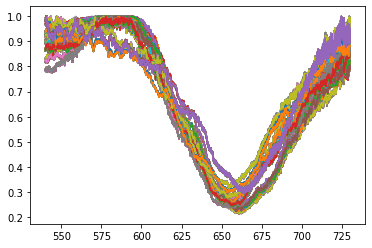

In [43]:
import matplotlib.pyplot as plt

for col in df:
	if col == 'wavelength':
		pass
	else:
		plt.plot(df['wavelength'], df[col])

In [ ]:
import numpy as np
import pandas as pd
def smooth(TransArray, WavArray, SmoothPoints=3):
    # for col in df:
	TransSmooth=[]
	SmoothMove=(SmoothPoints/2)-0.5
	SmoothMove=int(SmoothMove)
	print(f'sm = {SmoothMove}')
	for M in range(SmoothMove,(len(TransArray)-SmoothMove),1):
		Temp=0
		for L in range(M-SmoothMove,M+SmoothMove+1,1):
			Temp=Temp+TransArray[L]
		TransVal=Temp/SmoothPoints
		TransSmooth = TransVal)
	
	WavArray=WavArray[SmoothMove:len(WavArray)-SmoothMove]
	TransArray=TransSmooth
	return (TransArray, WavArray)


size = 20
# transarray = list(np.random.random_sample(size))
transarray = [1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7]
wavarray = list(range(100,140,2))
newtrans, newwav = smooth(transarray, wavarray)

df = pd.DataFrame({'wavelength':wavarray, 'transmission':transarray})
pdaverage = df.rolling(window=3).mean()

print((transarray[0]+transarray[1]+transarray[2])/3)
print((transarray[17]+transarray[18]+transarray[19])/3)
print(newtrans)
print(pdaverage)

## Generate Run List

In [1]:
import pandas as pd
import numpy as np
import lib.csv_helpers as csv
from IPython.display import display
import copy

instrument = {
    'name'              : 'instrument01',
    'sensor'            : 'DUM01',
    'element_map'       : { 'A01': 'Barium',
                            'A02': 'Bromine',
                            'A03': 'Lanthanum',
                            'A04': 'Titanium',
                            'B01': 'Chromium',
                            'B02': 'Arsenic',
                            'B03': 'Krypton',
                            'B04': 'Nitrogen',
                            'C01': 'Fluorine',
                            'C02': 'Manganese',
                            'C03': 'Cadmium',
                            'C04': 'Arsenic',
                            'D01': 'Argon',
                            'D02': 'Copper',
                            'D03': 'Aluminium',
                            'D04': 'Selenium',
                            },
    'light Source'      : 'Stellarnet LED White',
    'spectrometer'      : 'Stellarnet BlueWave VIS-25',
}

setup = {
    'output_dir'        : './dummydata',
    'fluids'            : ['water', 'beer1', 'beer2'],
    'elements'          : 'all',
    'repeats'           : 3,
    'wavelength_range'  : [400, 420, 0.5], #start, stop, step
    'primary_metadata'  : ['instrument', 'element', 'fluid'],
}


run_df = csv.generate_run_list(setup, instrument)

def dummyMeasurement(setup, row):
    

    #For a real instrument, may wish do adjust based on row['element']

    dummywavelength = list(np.arange(setup['wavelength_range'][0], #start
                                    setup['wavelength_range'][1],  #stop
                                    setup['wavelength_range'][2])) #step

    size = len(dummywavelength)
    dummydata = list(np.random.random_sample(size))
    dummycsv = {'wavelength' : dummywavelength, 'transmission' : dummydata}
    df = pd.DataFrame(data=dummycsv, dtype=np.float32)

    timestamp = pd.Timestamp.utcnow().timestamp()
    df.rename(columns={"transmission" : timestamp }, inplace=True)
    return df


csv.bulk_measurement(setup, run_df, dummyMeasurement)


INFO:root:Merging into existing ./dummydata/water/instrument01-A01-water.txt
INFO:root:Merging into existing ./dummydata/water/instrument01-A02-water.txt
INFO:root:Merging into existing ./dummydata/water/instrument01-A03-water.txt
INFO:root:Merging into existing ./dummydata/water/instrument01-A04-water.txt
INFO:root:Merging into existing ./dummydata/water/instrument01-B01-water.txt
INFO:root:Merging into existing ./dummydata/water/instrument01-B02-water.txt
INFO:root:Merging into existing ./dummydata/water/instrument01-B03-water.txt
INFO:root:Merging into existing ./dummydata/water/instrument01-B04-water.txt
INFO:root:Merging into existing ./dummydata/water/instrument01-C01-water.txt
INFO:root:Merging into existing ./dummydata/water/instrument01-C02-water.txt
INFO:root:Merging into existing ./dummydata/water/instrument01-C03-water.txt
INFO:root:Merging into existing ./dummydata/water/instrument01-C04-water.txt
INFO:root:Merging into existing ./dummydata/water/instrument01-D01-water.txt

date          datetime64[ns]
instrument            object
sensor                object
element               object
chemistry             object
fluid                 object
repeats                int64
hidden                  bool
comment              float64
dtype: object
date          datetime64[ns]
instrument            object
sensor                object
element               object
chemistry             object
fluid                 object
repeats                int64
hidden                  bool
comment               object
dtype: object


ValueError: You are trying to merge on object and float64 columns. If you wish to proceed you should use pd.concat

In [89]:
metadata['fluid'] = 'qwerty5'
# csv.store(df, metadata, path=setup['output_dir'] )

path=setup['output_dir']
metapath = os.path.join(path, "index.txt")
# meta_df = csv.read_metadata(metapath)

metadata['repeats'] = 3
metadata['element'] = '03'
metadata['date'] = pd.Timestamp.utcnow()
meas_id = '2022-03-01-DUM01-beer2-Dx8'
new_row= pd.Series(data=metadata, name=meas_id).to_frame().T
# print(meta_df['date'])
# meta_df = pd.concat([meta_df, new_row])
# meta_df.at[meas_id, 'repeats'] = metadata['repeats']
# # meta_df.iloc[1]['date']
# print(meta_df['date'])
# meta_df
new_row.index.name = "index"
new_row.to_csv(f'{metapath}', index=True, sep='\t', na_rep='', date_format='%Y-%m-%d')
# meta_df.to_csv(f'{metapath}', index=True, sep='\t', na_rep='', date_format='%Y-%m-%d')

In [4]:
import lib.dummydata

lib.dummydata.dummyChemistry(lib.dummydata.defaults)

{'A01': 'Barium',
 'A02': 'Bromine',
 'A03': 'Lanthanum',
 'A04': 'Titanium',
 'B01': 'Chromium',
 'B02': 'Arsenic',
 'B03': 'Krypton',
 'B04': 'Nitrogen',
 'C01': 'Fluorine',
 'C02': 'Manganese',
 'C03': 'Cadmium',
 'C04': 'Arsenic',
 'D01': 'Argon',
 'D02': 'Copper',
 'D03': 'Aluminium',
 'D04': 'Selenium'}